# Laplace inpainting

Laplace inpainting using the laplace discrete operator to recover missing pixels from an image

## Create image

Lets load a cat image !

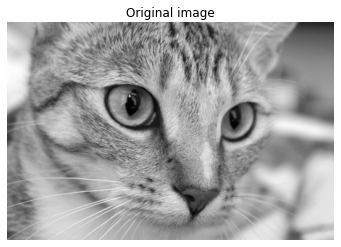

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color

# load cat image
original_img = skimage.img_as_float(skimage.color.rgb2gray(skimage.data.chelsea()))

# Draw cat image
plt.axis('off')
img = plt.imshow(original_img)
img.set_cmap('gray')
plt.title('Original image')
plt.show()

## Create a mask

Creating a mask which will be used to alter the image

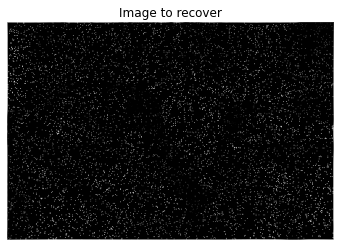

In [2]:
# Create a random mask
RATIO_OF_ZERO = 0.95 # percentage of zero
mask_img = np.random.rand(original_img.shape[0], original_img.shape[1])
mask_img[mask_img > RATIO_OF_ZERO] = 1.0
mask_img[mask_img <= RATIO_OF_ZERO] = 0.0
mask_img[0][:] = 1.0 # top row
mask_img[-1][:] = 1.0 # bottom row
mask_img[:,0] = 1.0 # left column
mask_img[:,-1] = 1.0 # right column
altered_img = original_img * mask_img

# Draw the image to recover
plt.axis('off')
img = plt.imshow(altered_img)
img.set_cmap('gray')
plt.title('Image to recover')
plt.show()

## Laplace inpainting

Image recovery by solving Laplace's Equation

    Jacobi method solves Ax=b where
    A contains the coefficient of the discrete laplace operator
    
    0 -1  0
    -1 4 -1
    0 -1  0
    
    x is the unknown discretized function (array)
    b is equal to zero
    By definition, The jacobi iteration is :
    xi(k+1) = 1/aii * (bi - sum(aij * xj(k)) 'where j!=i')
    because b is a zero array and aii reference the coefficient 4
    xi(k+1) = 1/4 * (- sum(aij * xj(k)) 'for j!=i')
    and aij are -1 for j!=i
    => xi(k+1) = 1/4 * (sum(xj(k)) 'for j!=i')

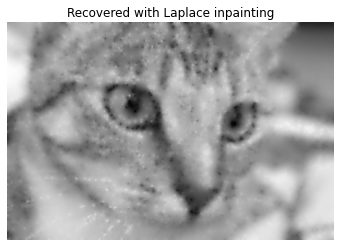

In [3]:
@numba.njit
def jacobi_solver(x, next_x, mask_indices):
    for it in numba.prange(len(mask_indices)):
        mask_index = mask_indices[it]
        i = mask_index[0]
        j = mask_index[1]
        next_x[i][j] = (x[i-1][j] + x[i+1][j] + x[i][j-1] + x[i][j+1]) * 0.25
        
JACOBI_ITERATIONS = 500
mask_indices = np.argwhere(mask_img == 0)
buffer = [np.copy(altered_img), np.copy(altered_img)]
for iteration in range(JACOBI_ITERATIONS):
    jacobi_solver(buffer[0], buffer[1], mask_indices)
    buffer[0], buffer[1] = buffer[1], buffer[0] # swap buffers
    
# Draw the image to recover
recovered_img = buffer[0]
plt.axis('off')
img = plt.imshow(recovered_img)
img.set_cmap('gray')
plt.title('Recovered with Laplace inpainting')
plt.show()